# Aim
Are there any clusters of local optima of various subgraphs

## Basics

In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
sys.path.append('home/egupta/.local/bin')

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import scipy.stats as ss
import networkx as nx
import csv 
import numpy as np
import seaborn as sns
from scipy.optimize import curve_fit
import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline


##qtensor imports
import qtensor
from qtensor import QAOA_energy
from qtensor import parameter_optimization as popt

2021-07-09 07:39:30,535- WARNING•	QuickBB solver is unavailable
2021-07-09 07:39:30,537- WARNING•	Tamaki solver is unavailable: No path /home/egupta/.local/lib/python3.7/site-packages/thirdparty/tamaki_treewidth


In [3]:
import torch

# Tranferability  Matrix for random subgraphs

In [4]:
## Old Code
#@title
from matplotlib import pyplot
from matplotlib import gridspec


def get_edge_contribution(graph, edge, gamma, beta):
    sim = qtensor.QtreeSimulator()
    composer = qtensor.DefaultQAOAComposer(graph, gamma=gamma, beta=beta)
    composer.energy_expectation_lightcone(edge)
    return np.real(sim.simulate_batch(composer.circuit)[0])

def transferability_matrix(graphs, multistart=10, steps=100):
    sim = WithoutQAOASimulator(QtreeQAOAComposer)
    matrix_loss = np.zeros((len(graphs), len(graphs)))
    for i, donor in enumerate(graphs):
        print(f"{i + 1}/{len(graphs)}")
        for s in range(multistart):
            gamma, beta = [np.random.rand()], [np.random.rand()]
            params, loss = get_qaoa_params(donor, edge=(0,1), gamma=gamma, beta=beta, steps=steps)
            gamma_opt, beta_opt = params[0][0], params[1][0]
            print('donor loss ' + str(loss))
            for j, acceptor in enumerate(graphs):
                trloss = get_edge_contribution(acceptor, (0,1), *params)
                print('acceptor loss' + str(trloss))
                similarity = trloss*loss/np.sqrt(trloss**2 + loss**2 + 0.001)
                matrix_loss[i,j] += similarity
    return matrix_loss


def sub_all(d1, d2, draw=False):
    # returns a list of subgraphs of all graphs with nodes of the central edge having degree d1 and d2
    A = np.zeros((d1 + d2, d1 + d2))
    A[d1 + 1:, d1] = 1
    A[:d1 - 1, d1 - 1] = 1
    A[d1 - 1, :d1 - 1] = 1
    A[d1, d1 + 1:] = 1
    A[d1, d1 - 1] = 1
    A[d1 - 1, d1] = 1
    
    g = nx.from_numpy_matrix(np.array(A))

    g_list = [g]
    for i in range(min(d1, d2) - 1):
        g = g_list[i]
        g_list.append(nx.contracted_nodes(g, i, i + d1 + 1))
    # relabel center edge as (0, 1)
    for i, g in enumerate(g_list):
        g_list[i] = qtensor.tools.lightcone_orbits.relabel_edge_first(g, (d1 - 1, d1))
        if draw:
            nx.draw_kamada_kawai(g)
            plt.show()
    return g_list

In [5]:
## My Code
def get_qaoa_params(graph, edge=(0,1), gamma=[0.5], beta=[0.5], steps=50):
    loss_history, params_history = popt.qaoa_maxcut_torch(graph, gamma, beta,
                                                          ordering_algo='greedy',
                                                          Opt=torch.optim.RMSprop,
                                                          edge=edge,
                                                          opt_kwargs=dict(lr=0.002),
                                                          steps=steps,
                                                          pbar=False)
    best_ix = np.argmin(loss_history)
    return params_history[best_ix], loss_history[best_ix]

In [6]:
def subgraph_optimal_param_and_cost(graph, edge, p, seeds, steps):
    '''
    Optimize parameters of a subgraph, do so (seed) many times with random initial
    ized parameters

    Return: array of Results of (seed) many optimization runs and the index of 
    array corresponding to max energy
    '''
    results = []
    s = 0 #iterator
    max_energy = -1
    max_index = 0

    while s<seeds:
        gamma = [np.random.rand() for i in range(p)]
        beta = [np.random.rand() for i in range(p)]
        params, loss = get_qaoa_params(graph, edge=(0,1), gamma=gamma, beta=beta, steps=steps)
        gamma_opt, beta_opt = params[0], params[1]
        energy = (1-loss)/2
        result = [gamma_opt, beta_opt, energy]
        results.append(result)

        # comparing with max
        if energy >max_energy:
            max_index = s
            max_energy = energy
        s+=1
    max_result = results[max_index]
    return max_result

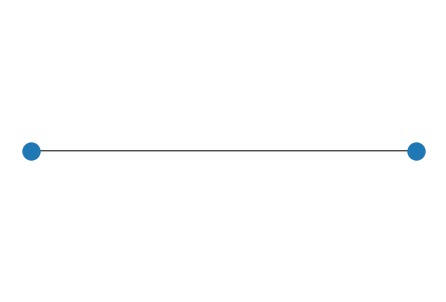

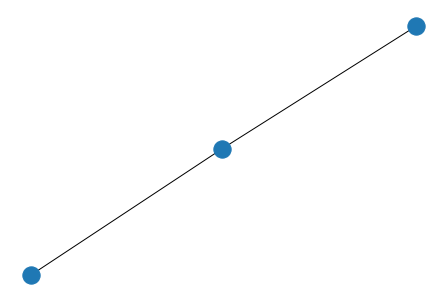

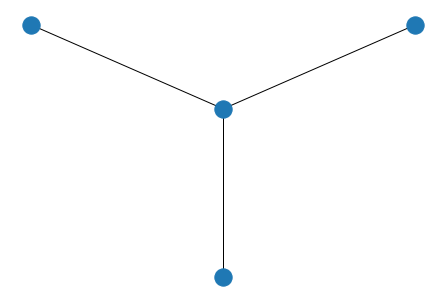

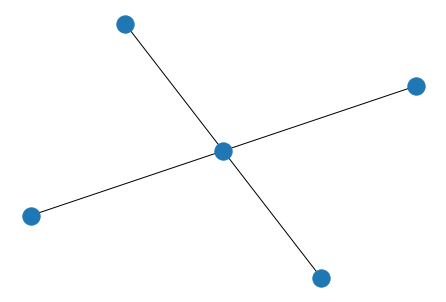

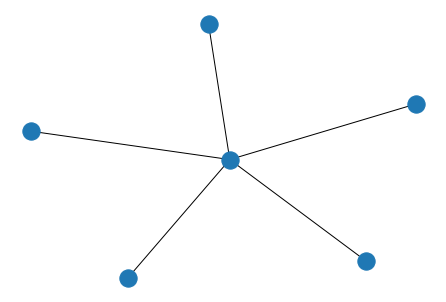

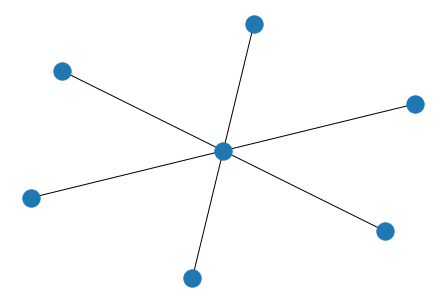

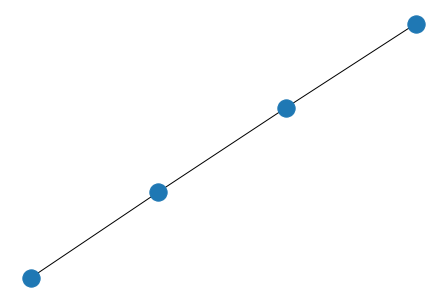

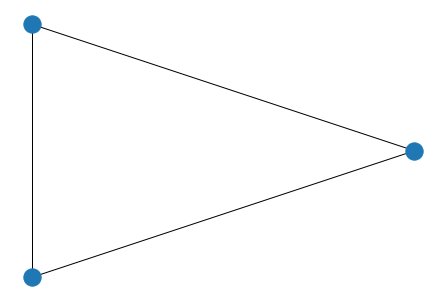

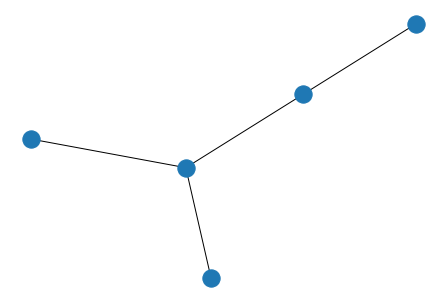

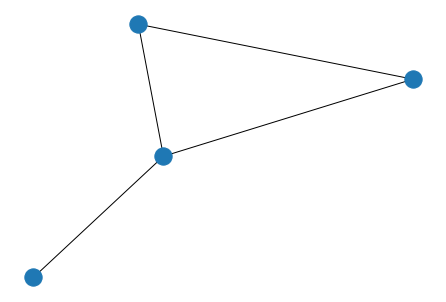

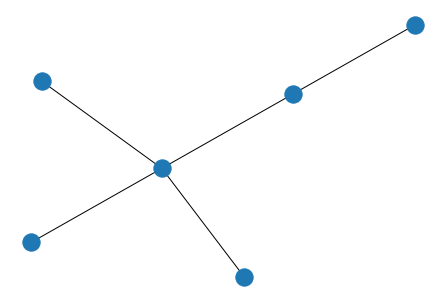

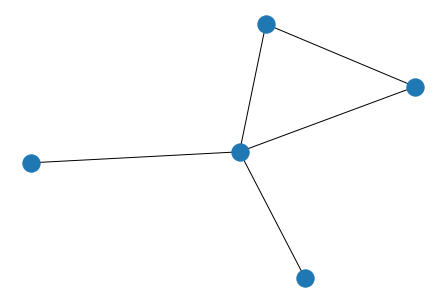

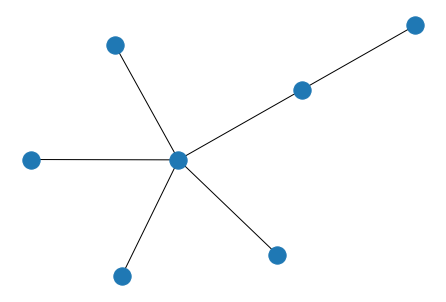

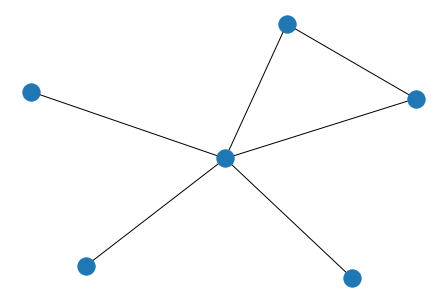

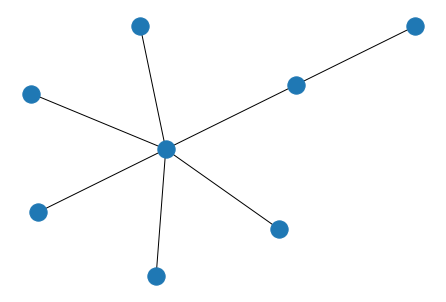

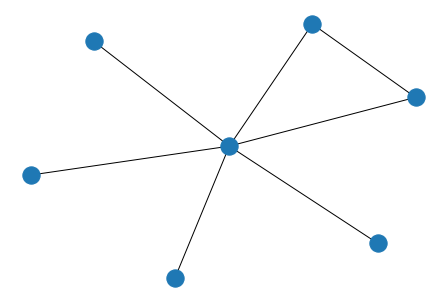

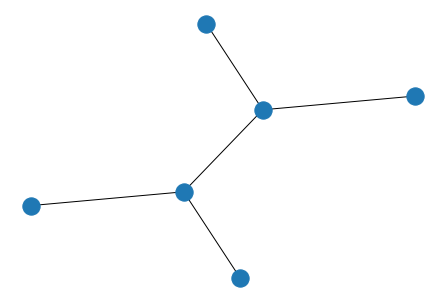

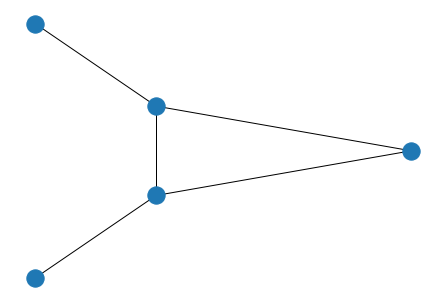

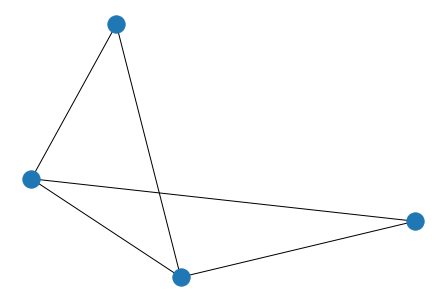

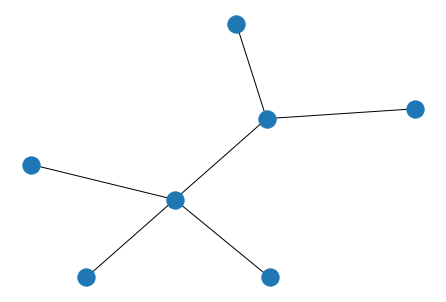

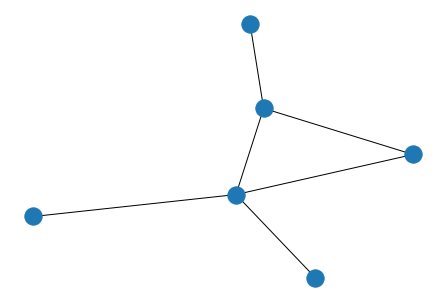

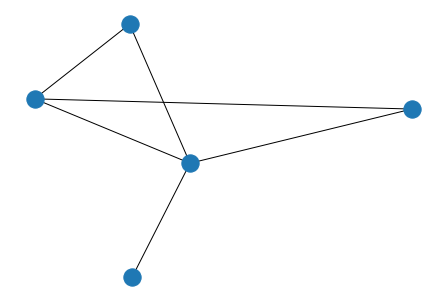

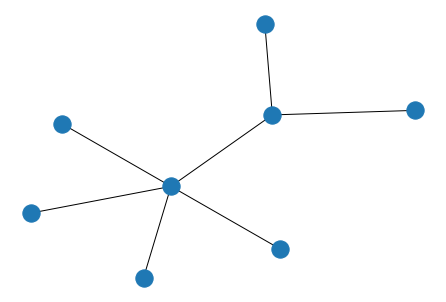

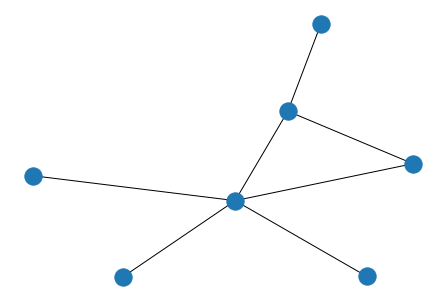

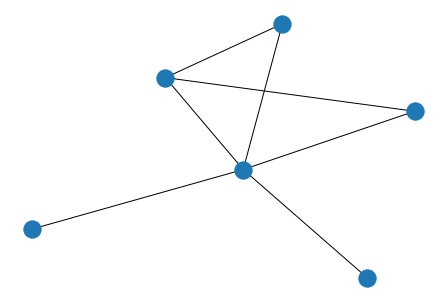

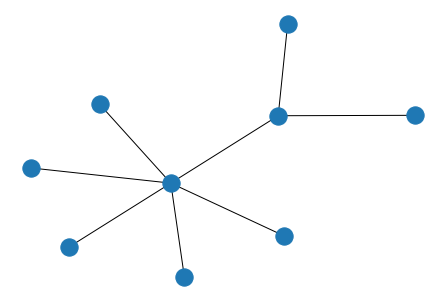

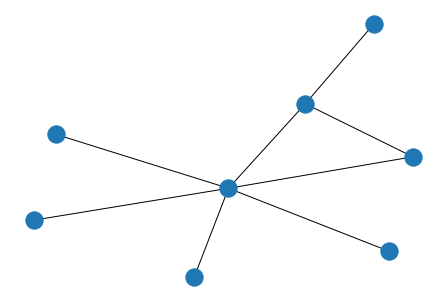

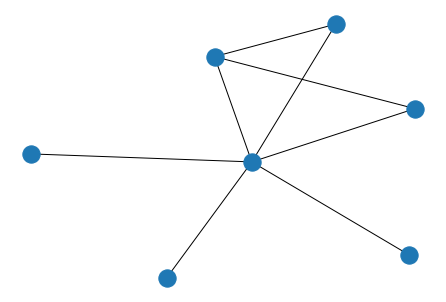

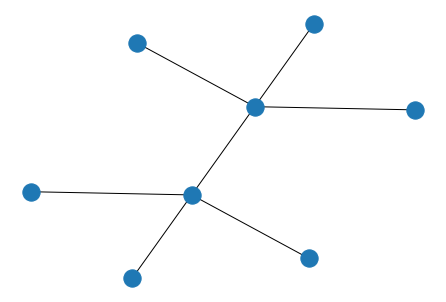

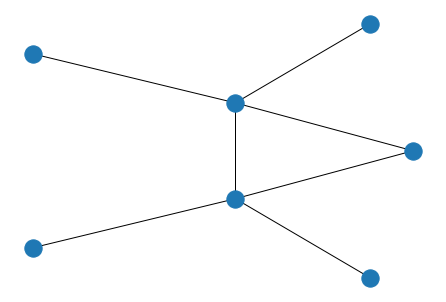

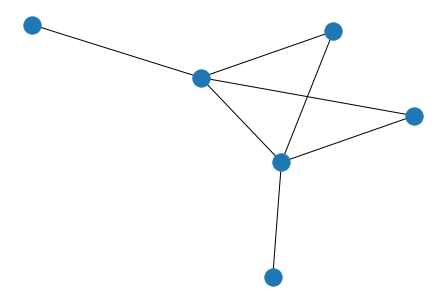

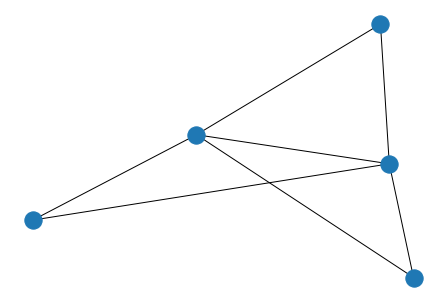

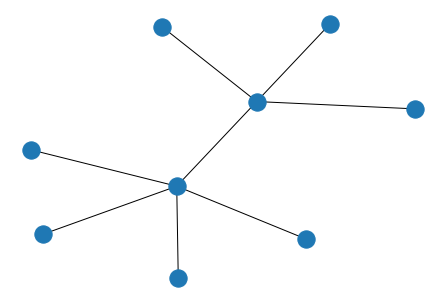

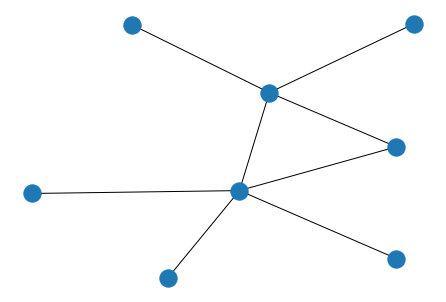

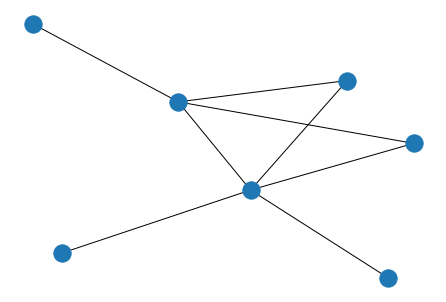

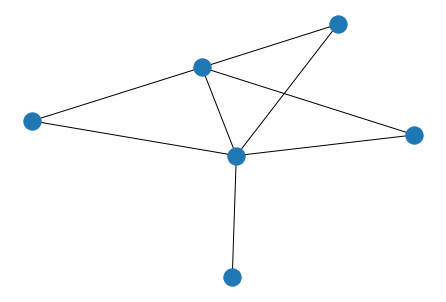

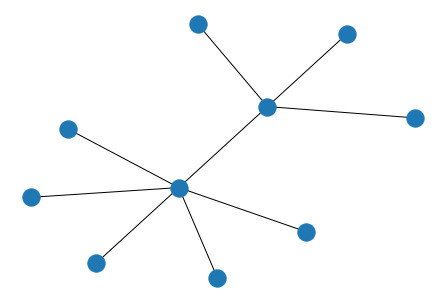

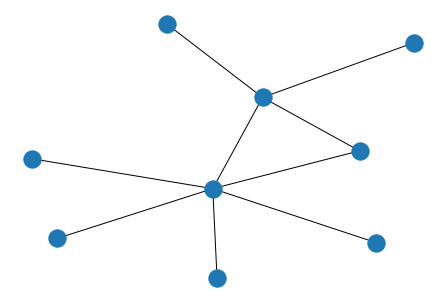

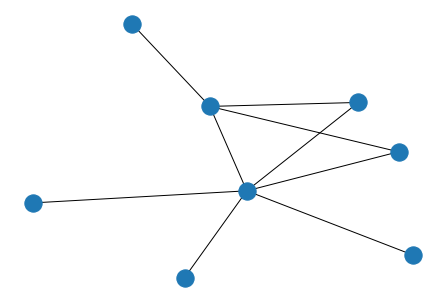

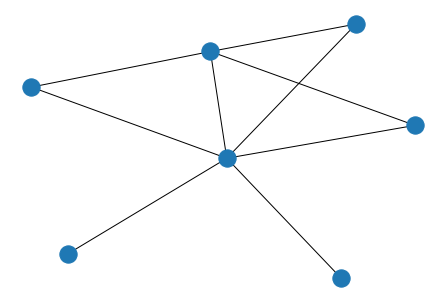

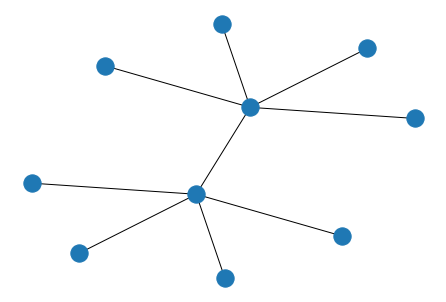

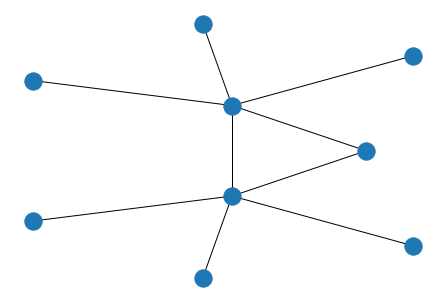

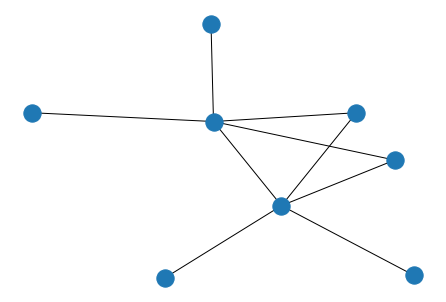

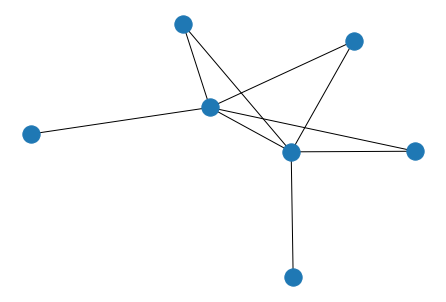

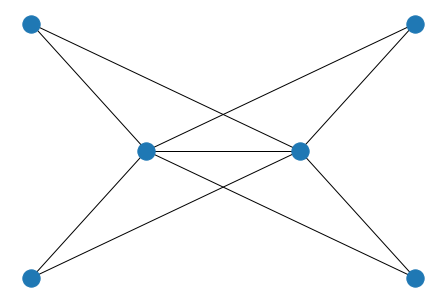

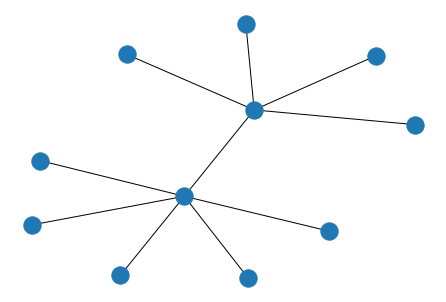

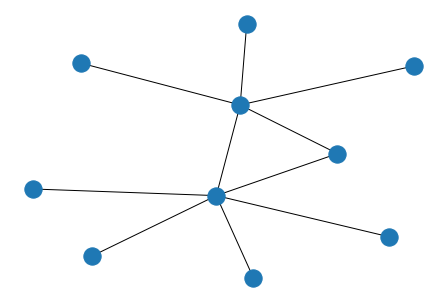

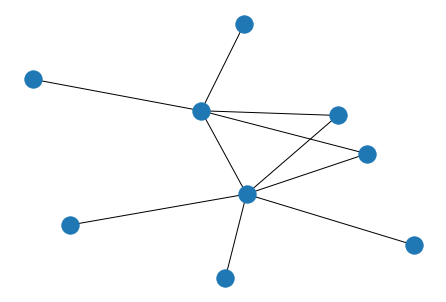

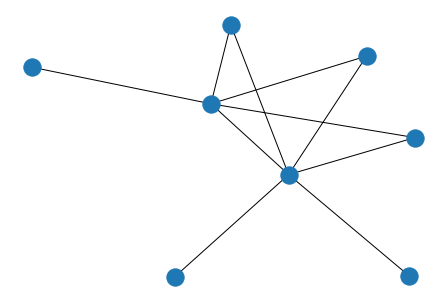

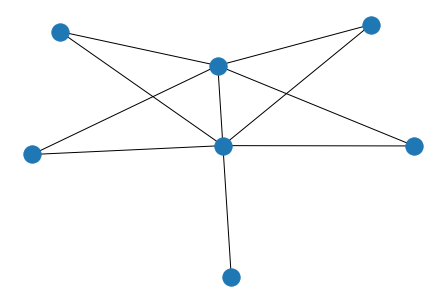

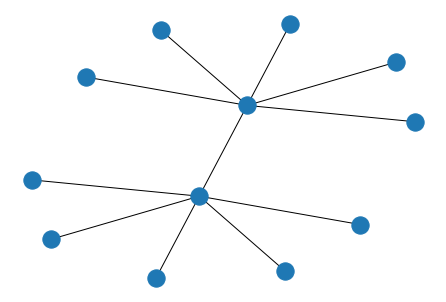

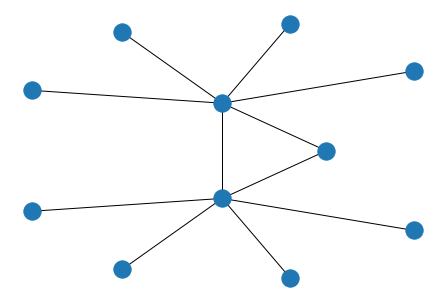

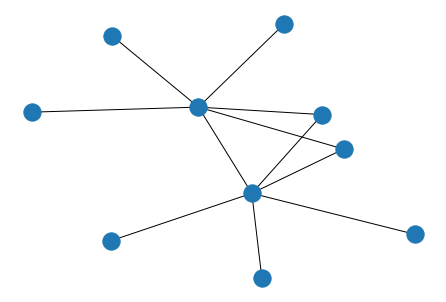

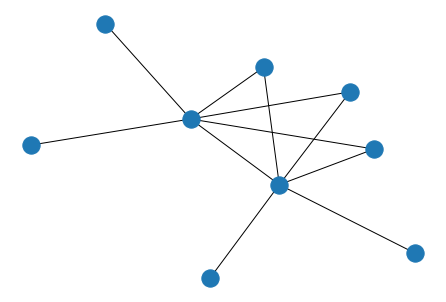

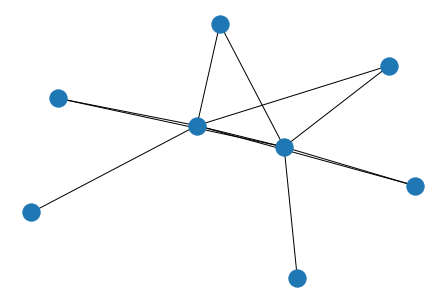

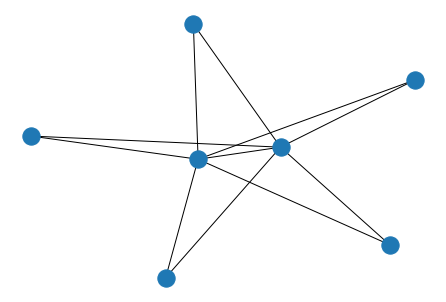

In [7]:
#generating all subgraphs first 
d_min = 1
d_max = 6
g_all = []
for i in range(d_min, d_max + 1):
    for j in range(i, d_max + 1):
        g_sub_ij = sub_all(i, j, draw=True)
        g_all += g_sub_ij

In [8]:
len(g_all)

56

In [9]:

def get_local_optima(subgraph,cutoff = 0.5, edge=(0,1), steps=50, multistarts =20):
    """
    Given a subgraph return those witin 10% of global
    """
    all_params = []
    all_energies = []
    for m in range(multistarts):
        
        p=1
        gamma = [np.random.rand() for i in range(p)]
        beta = [np.random.rand() for i in range(p)]
        loss_history, params_history = popt.qaoa_maxcut_torch(subgraph, gamma, beta,
                                                              ordering_algo='greedy',
                                                              Opt=torch.optim.RMSprop,
                                                              edge=edge,
                                                              opt_kwargs=dict(lr=0.002),
                                                              steps=steps,
                                                              pbar=False)
        energies_history = [(1-loss)/2 for loss in loss_history]
        
        all_params+=params_history
        all_energies+=energies_history
    
    #print(all_energies)
    best_index = np.argmax(all_energies)
    best_energy = float(all_energies[best_index])
    best_param = all_params[best_index]
    
    #storing data for local optima
    local_params= [best_param]
    local_energies = [best_energy]
    
    #add all local
    for i in range(len(all_energies)):
        energy = all_energies[i]
        params = all_params[i]
        
        if (abs(energy-best_energy)/best_energy)<cutoff:
            local_params.append(params)
            local_energies.append(energy)
    
        
    return local_params, local_energies

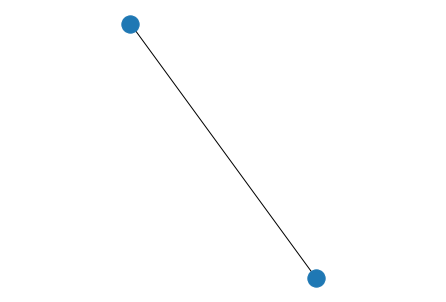

In [40]:
k= 0
sub = g_all[k]
nx.draw(sub)

In [41]:
params, local= get_local_optima(sub,cutoff = 0.01, multistarts =20)

In [42]:
len(local)

504

In [43]:
def fix_param(params):
    """
    Assuming gamma ranges from 0 to 1 and beta from 0 to 0.5 and both are preiodic
    """
    new_params = []
    for p in params:
        gamma = float(p[0])
        beta = float(p[1])
        gamma = gamma%1
        beta = beta%0.5
        new_params.append([gamma, beta])
    return new_params

In [44]:
params = fix_param(params)

No handles with labels found to put in legend.


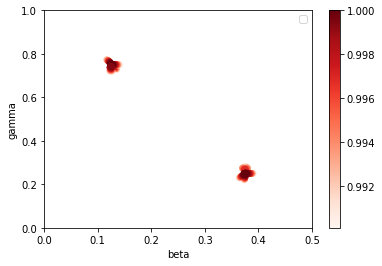

In [45]:
gamma = [float(params[i][0]) for i in range(len(params))]
beta = [float(params[i][1]) for i in range(len(params))]\

cm = plt.cm.get_cmap('Reds')

plt.scatter(beta, gamma, c = local, cmap = cm)
plt.colorbar()
#plt.plot(beta[0], 'bo', label = 'global')
plt.xlabel('beta')
plt.ylabel('gamma')
plt.axis([0, 0.5, 0, 1])
plt.legend()
plt.show()

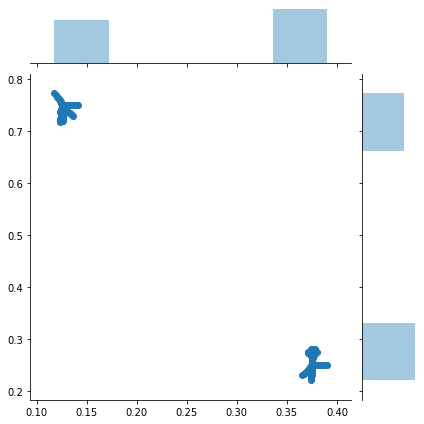

In [46]:
import seaborn as sns
sns.jointplot(x=beta, y=gamma)
plt.show()

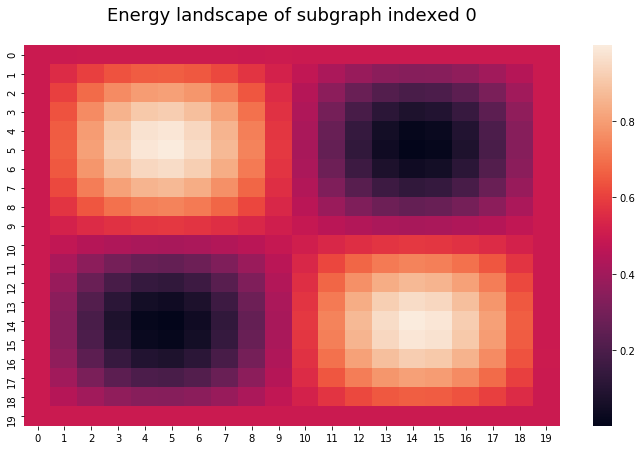

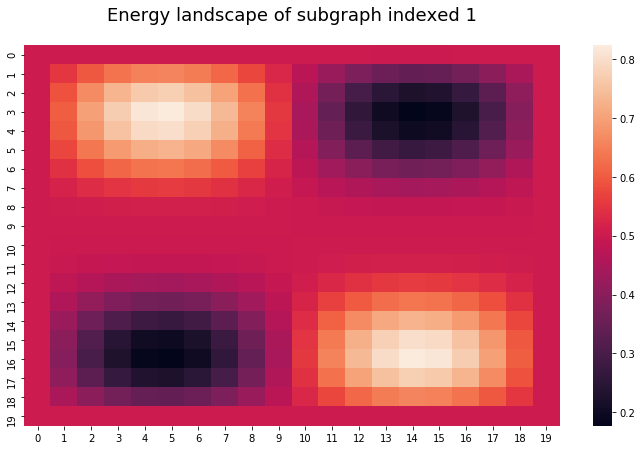

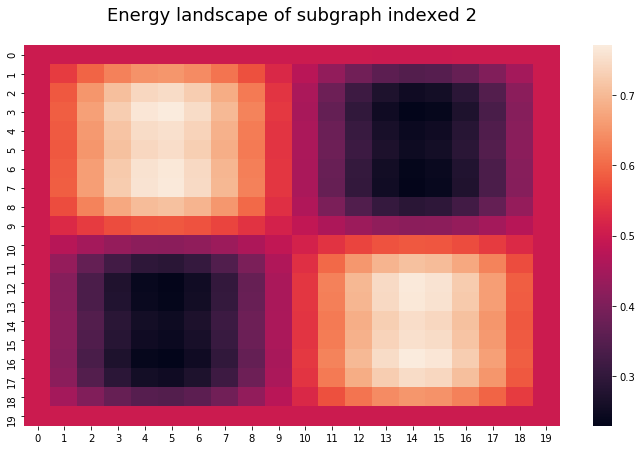

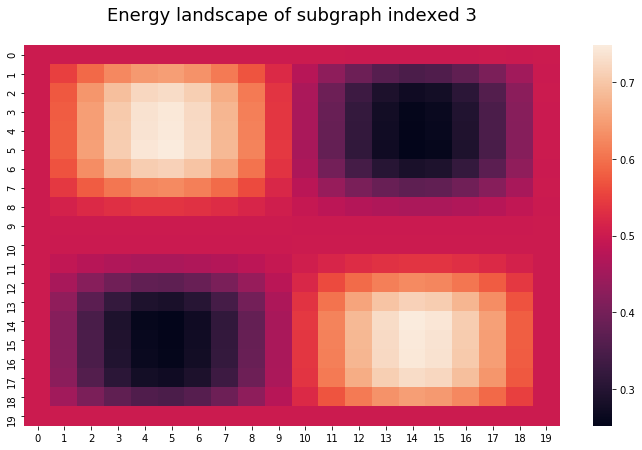

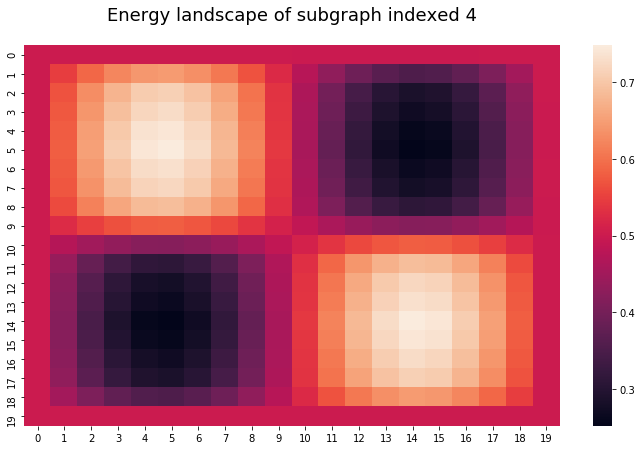

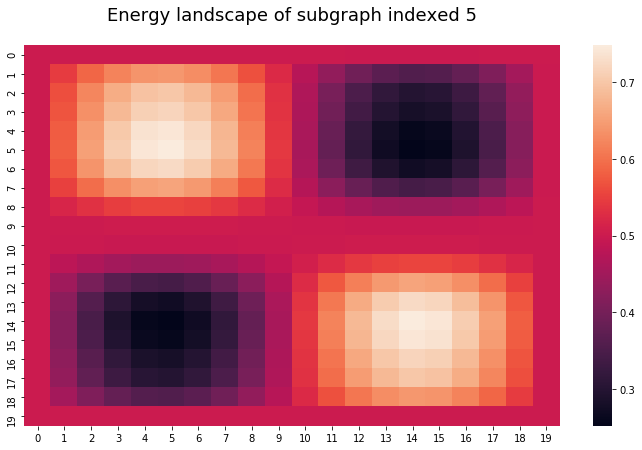

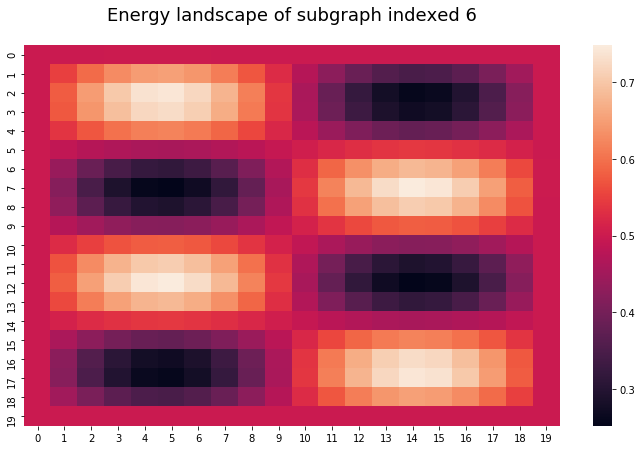

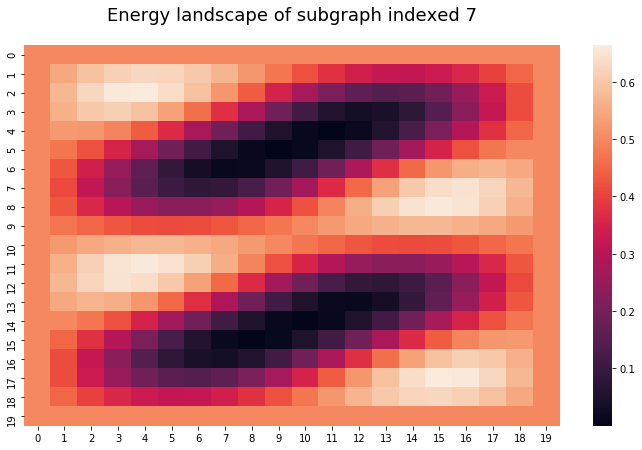

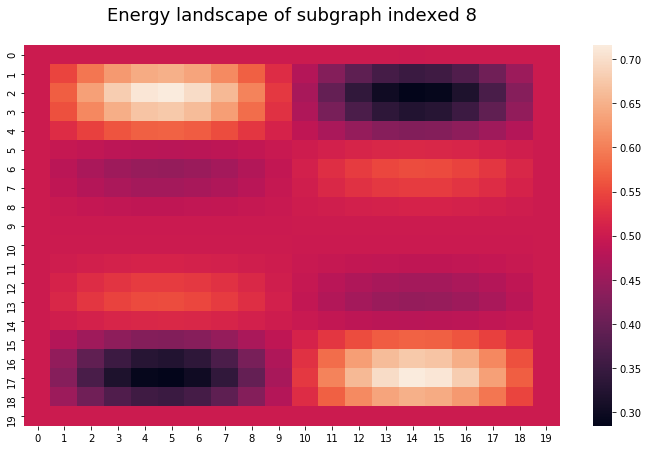

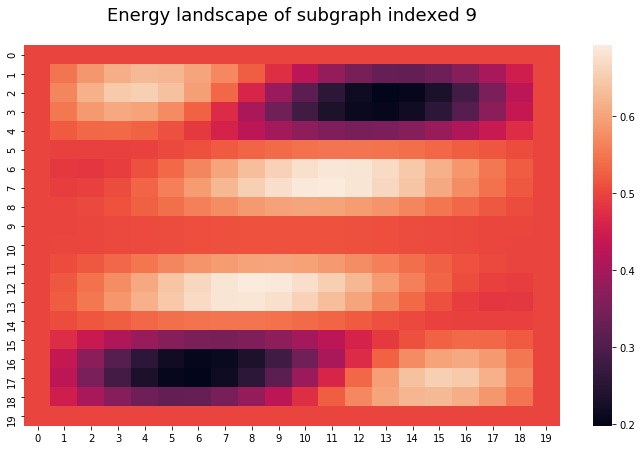

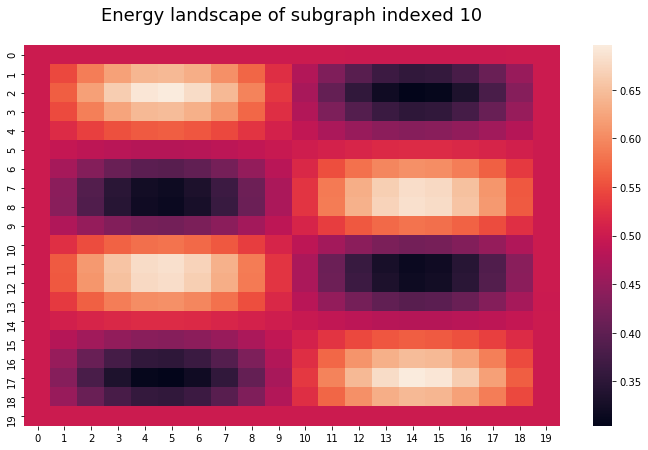

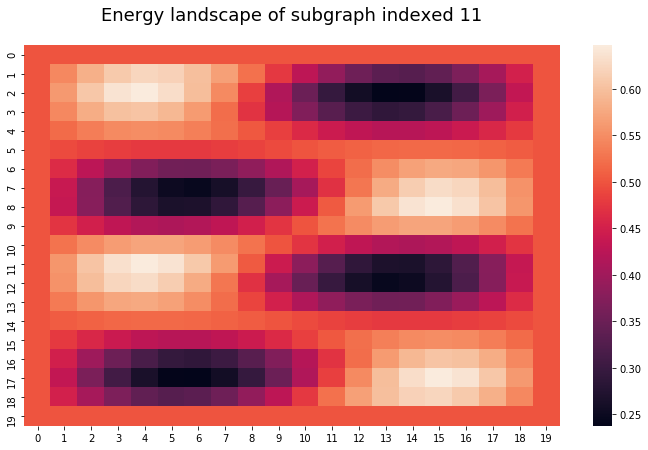

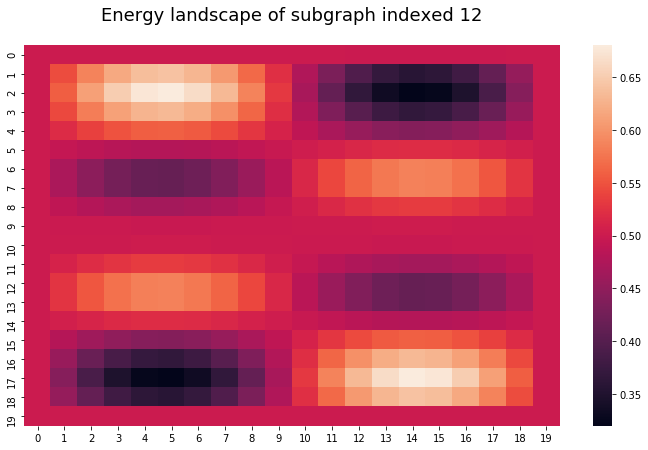

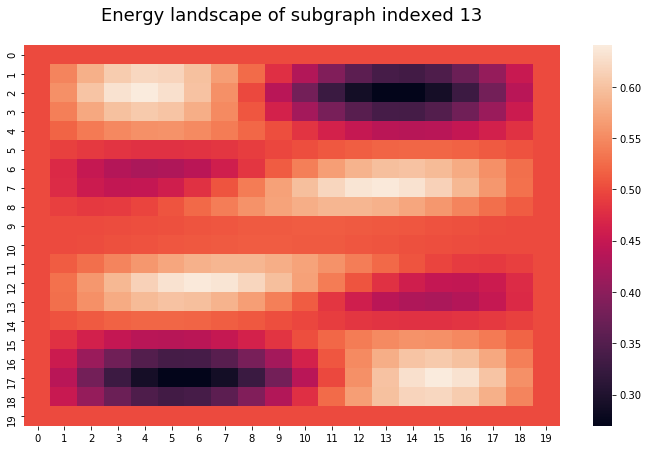

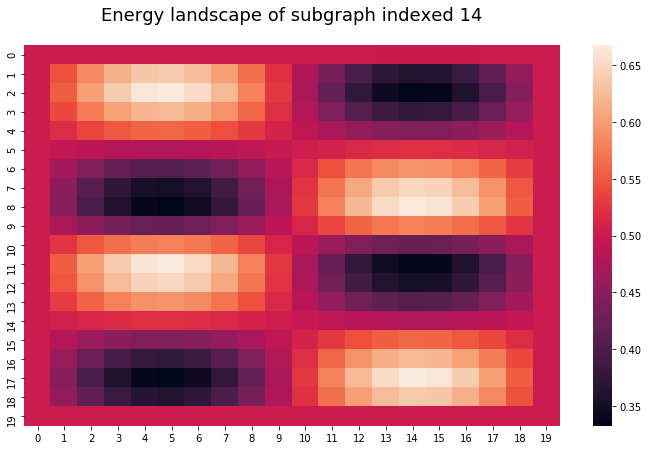

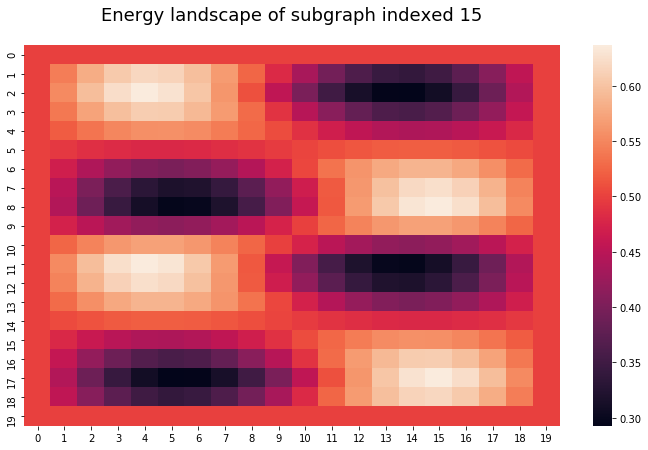

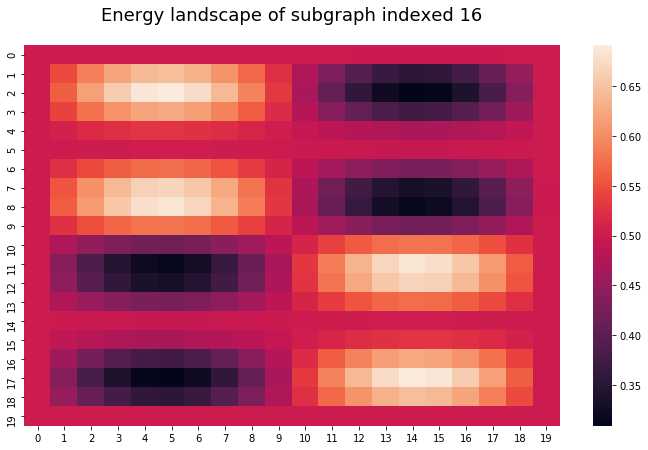

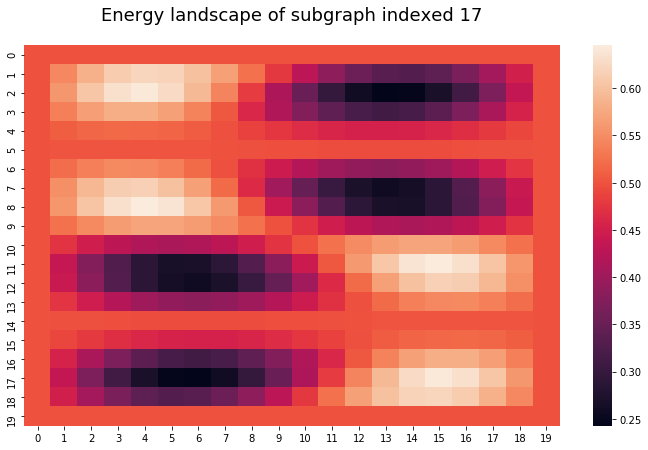

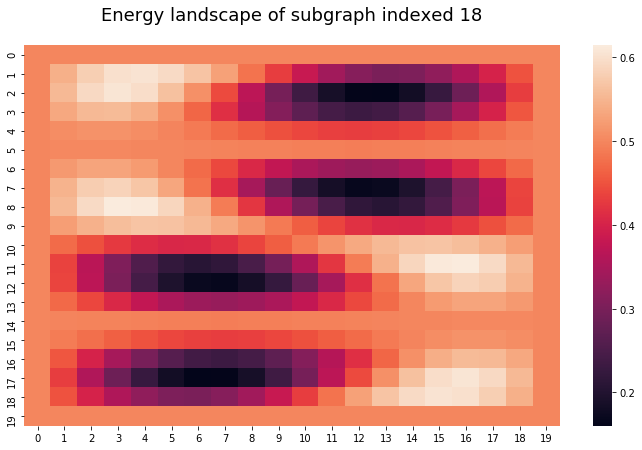

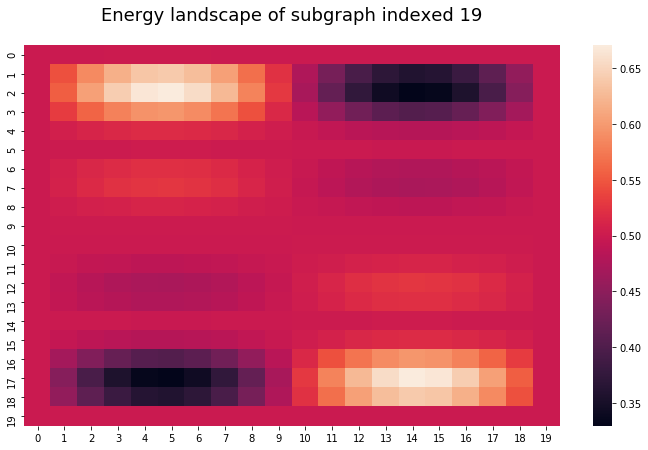

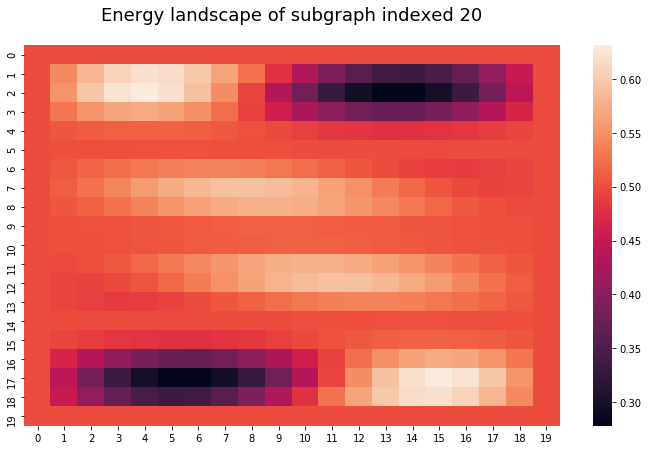

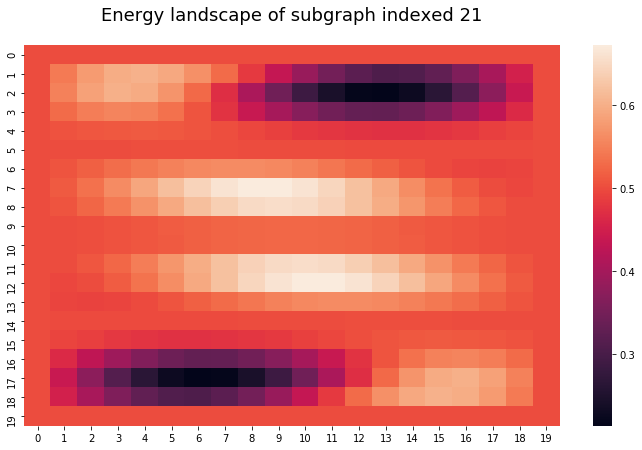

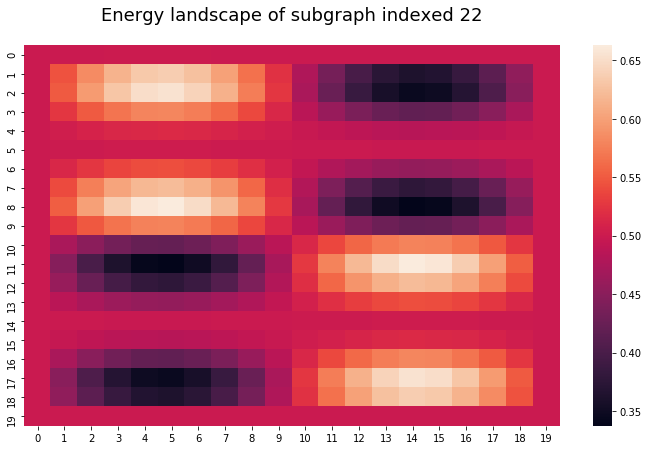

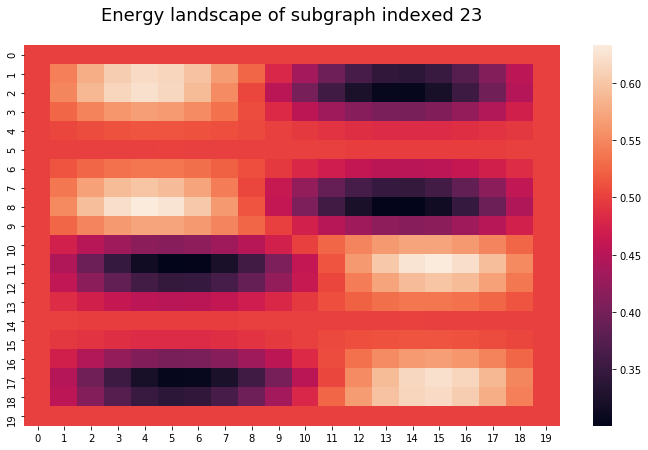

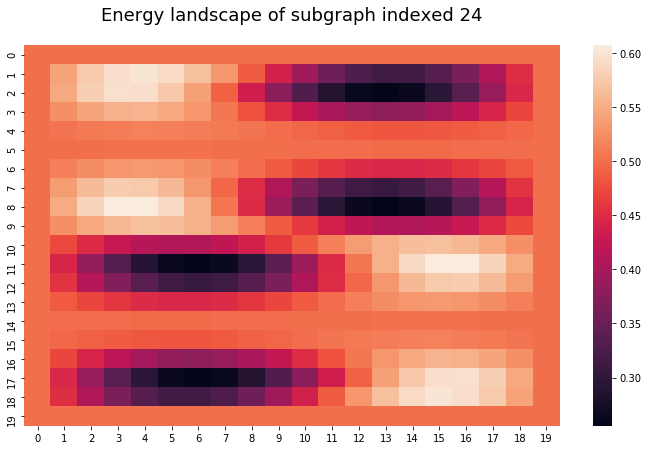

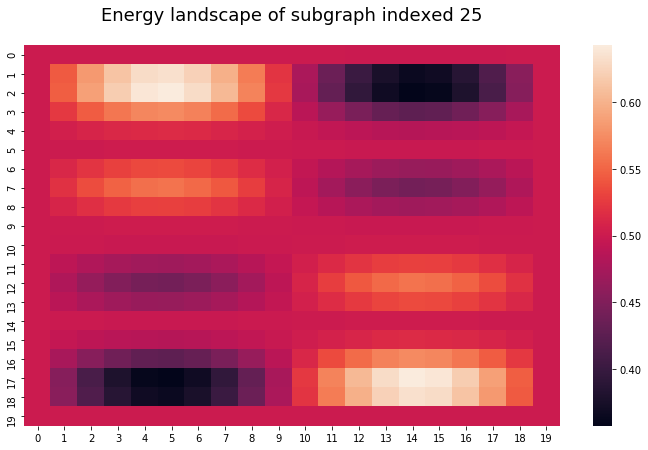

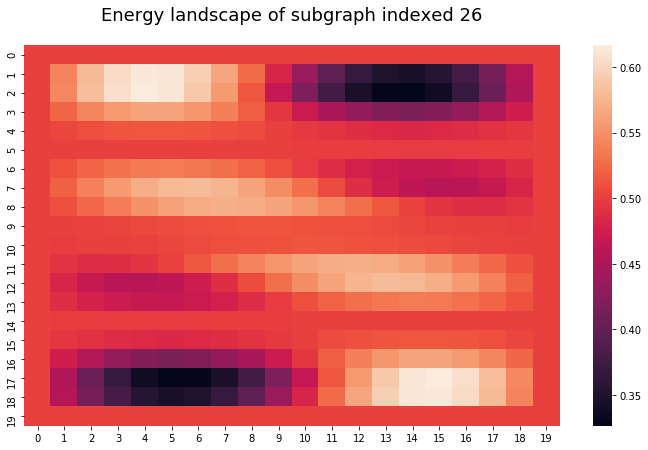

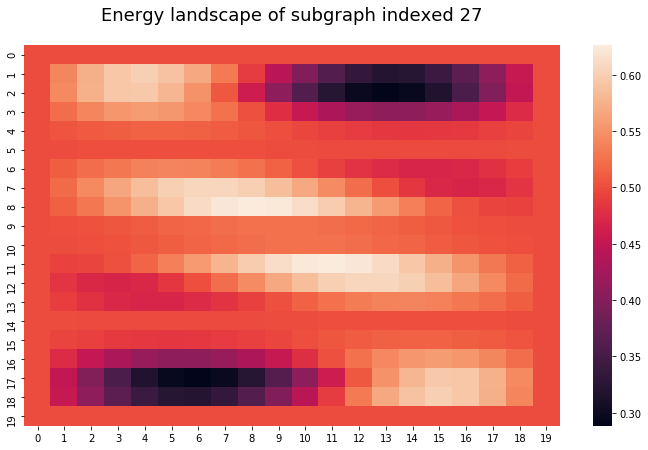

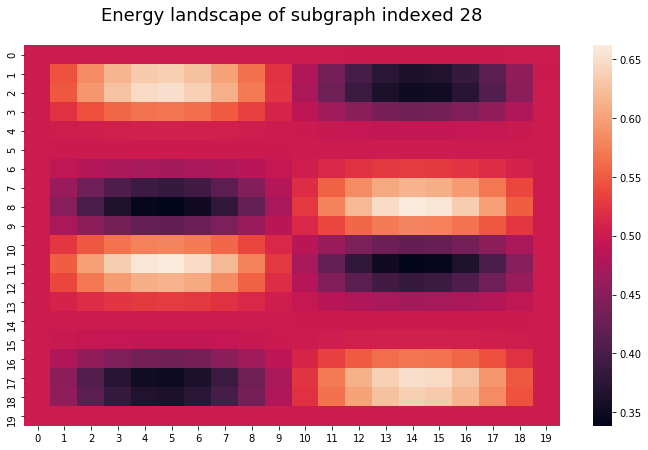

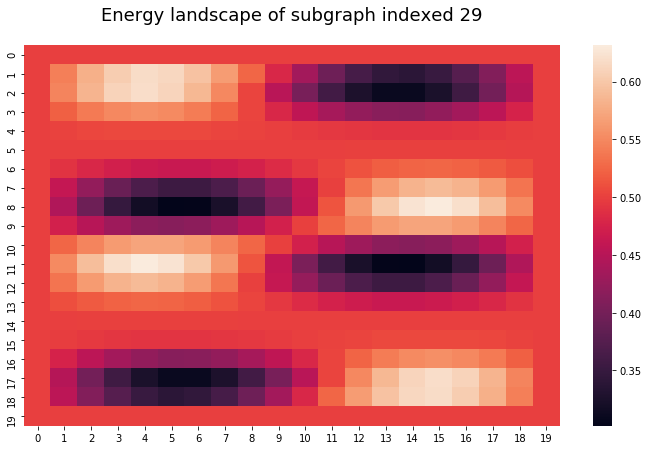

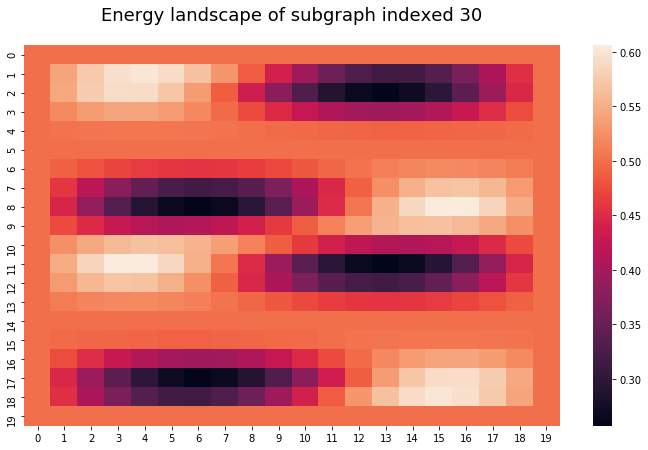

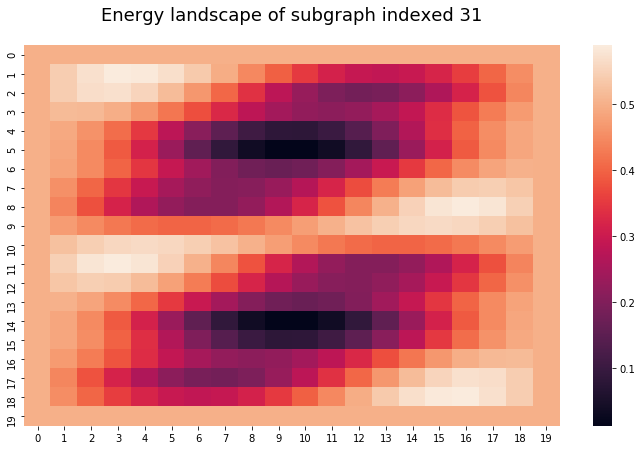

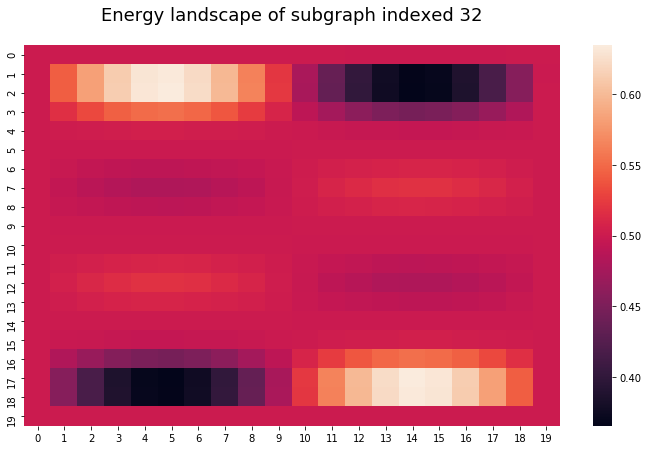

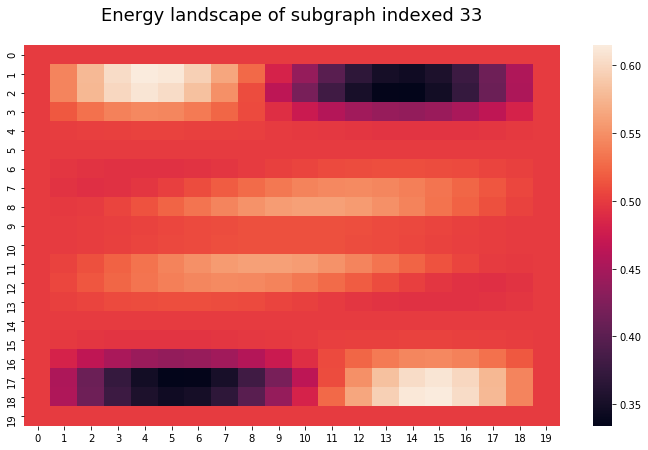

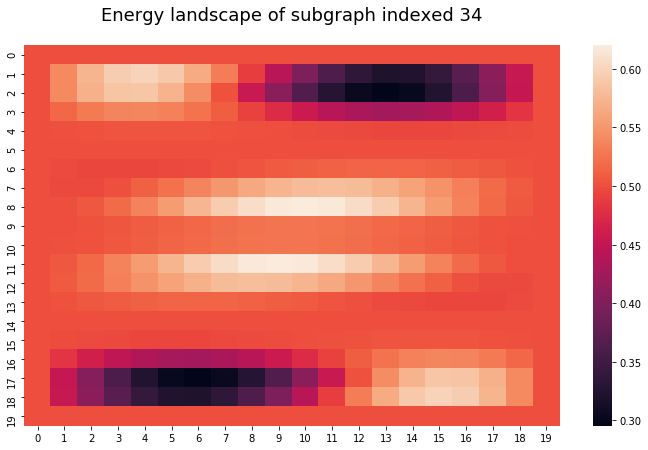

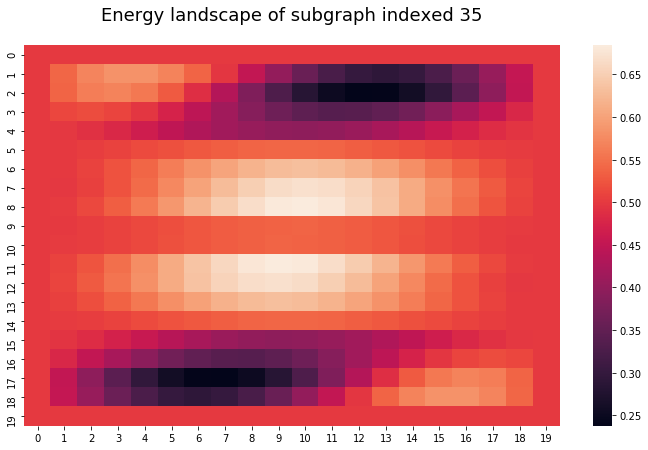

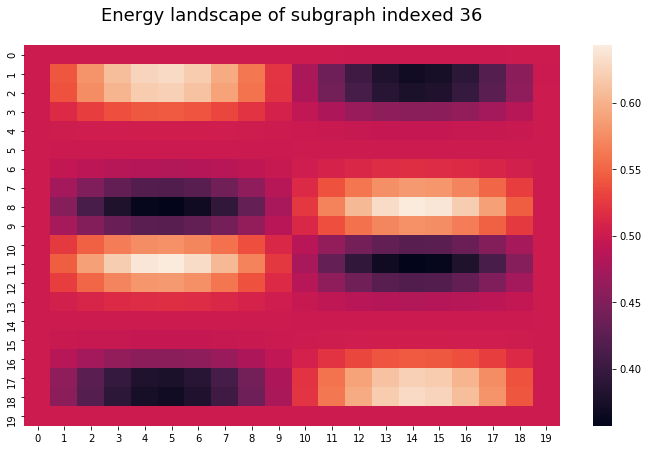

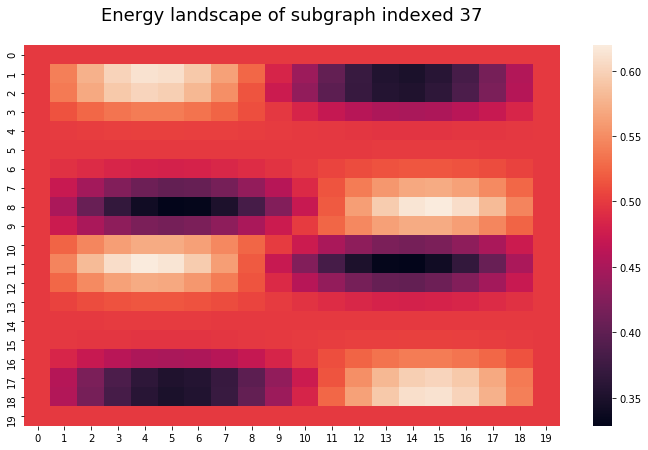

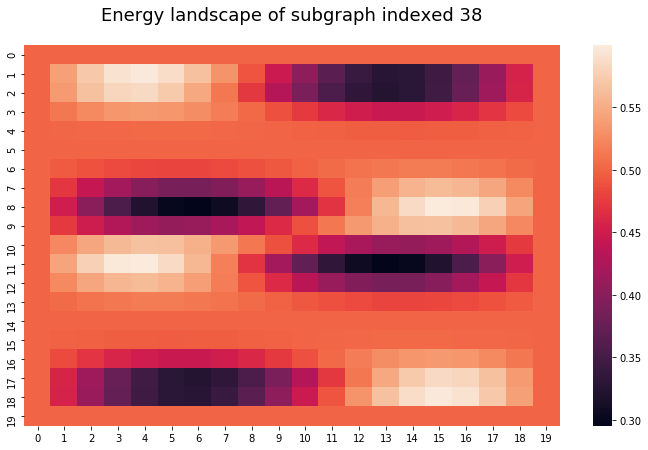

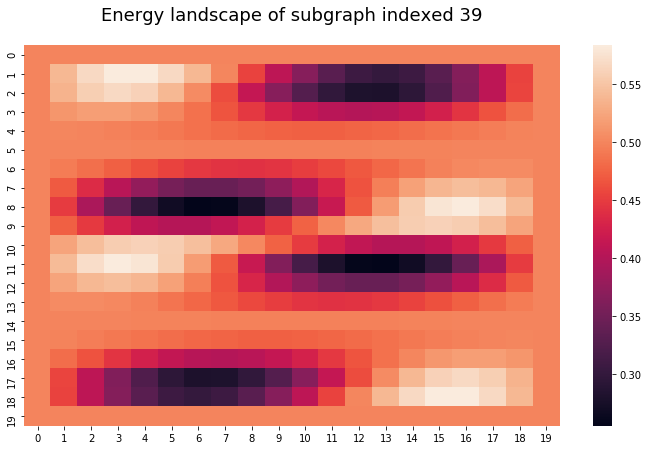

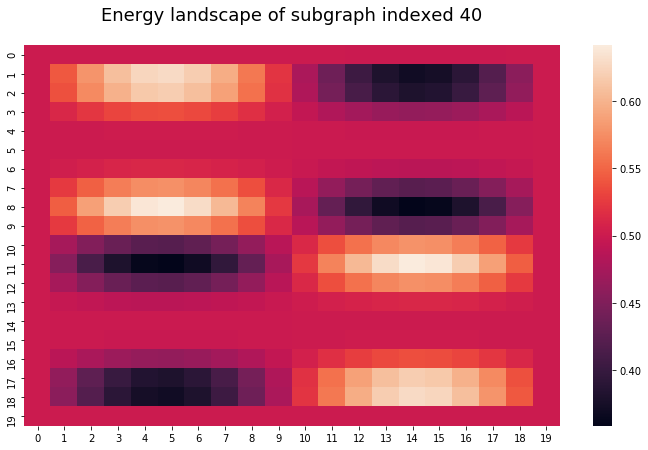

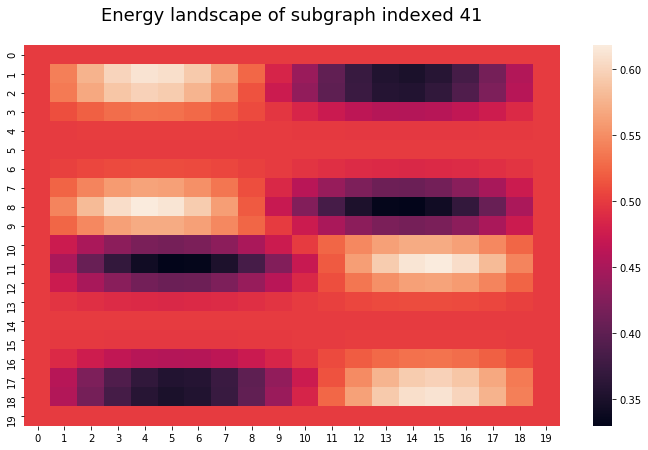

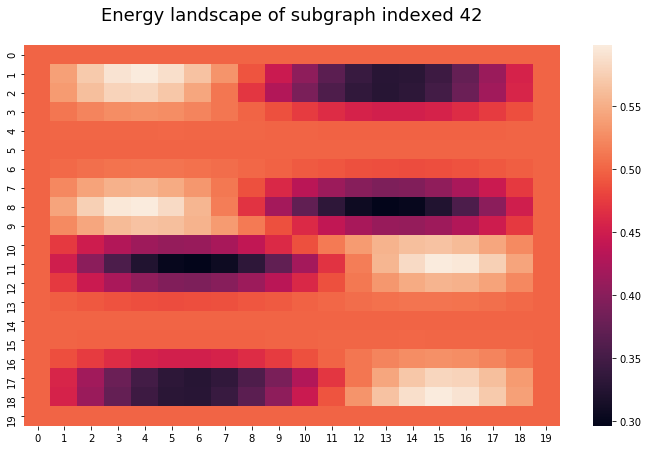

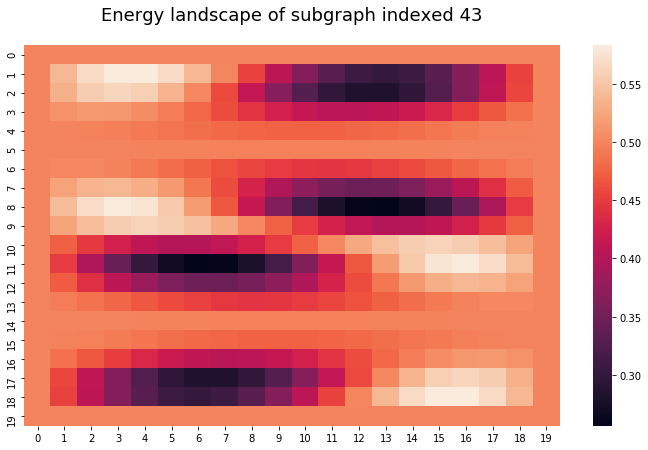

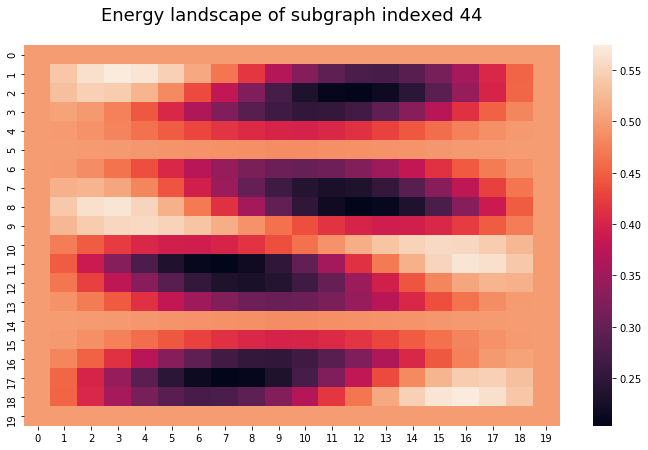

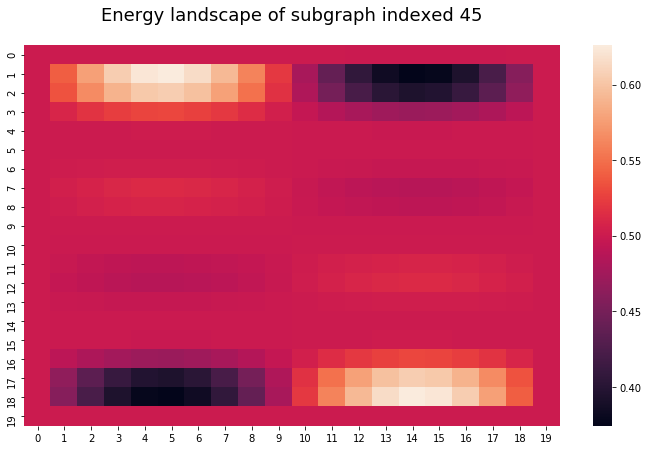

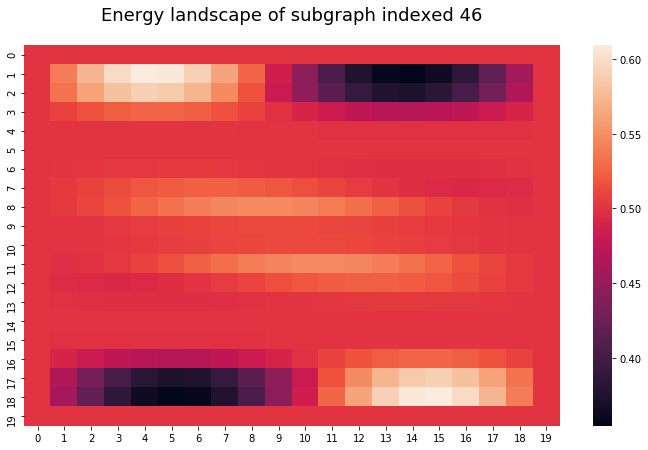

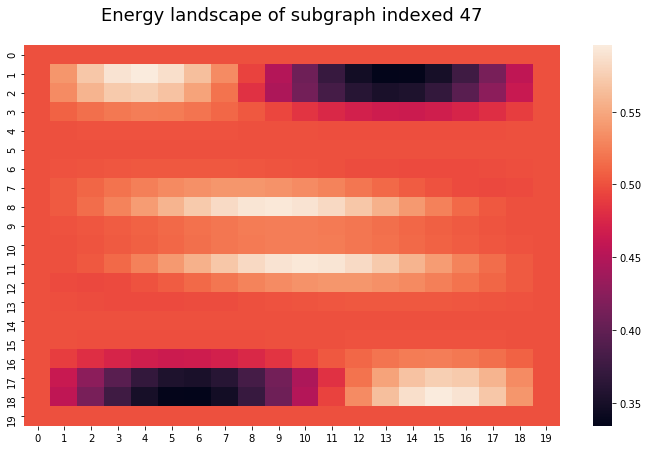

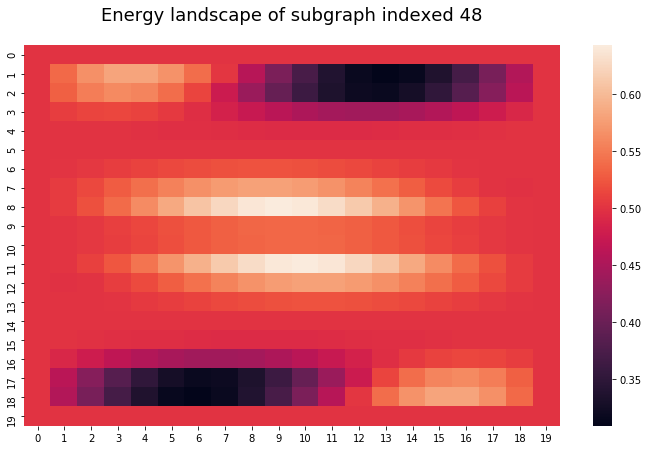

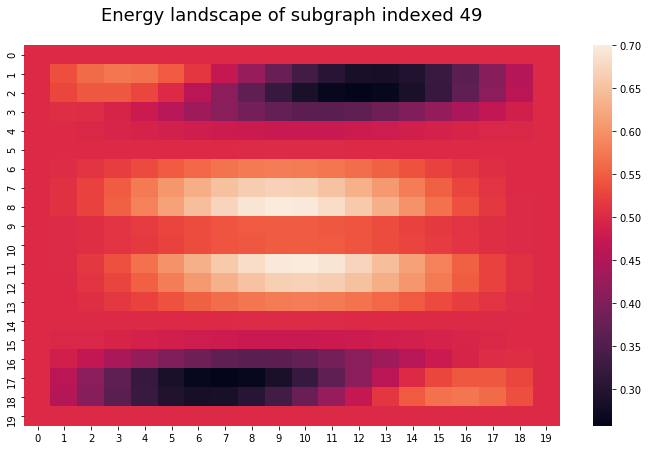

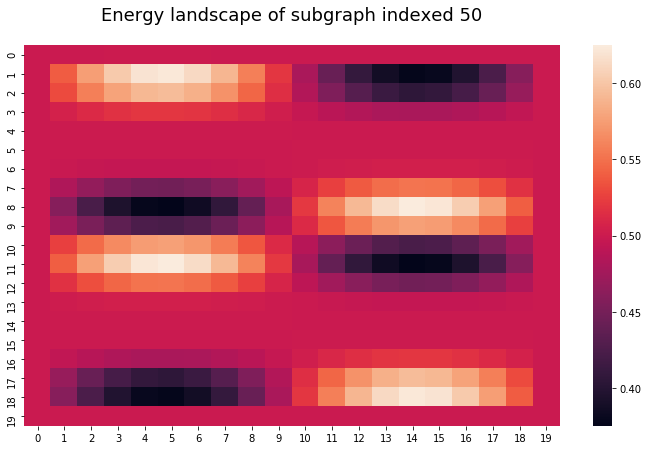

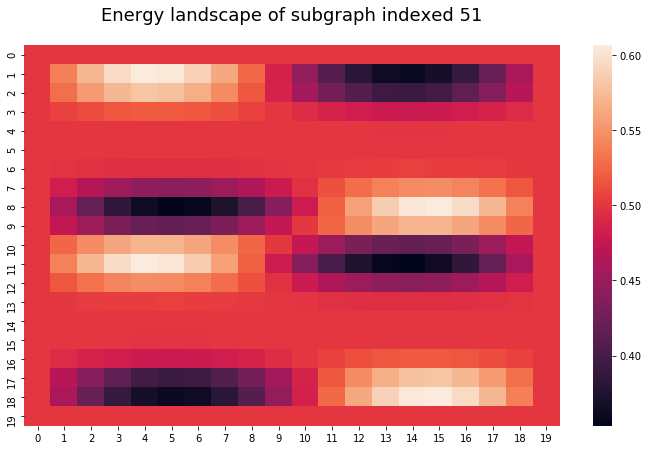

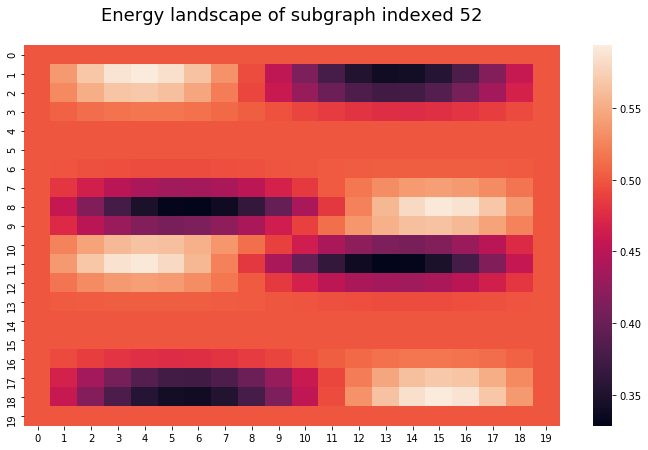

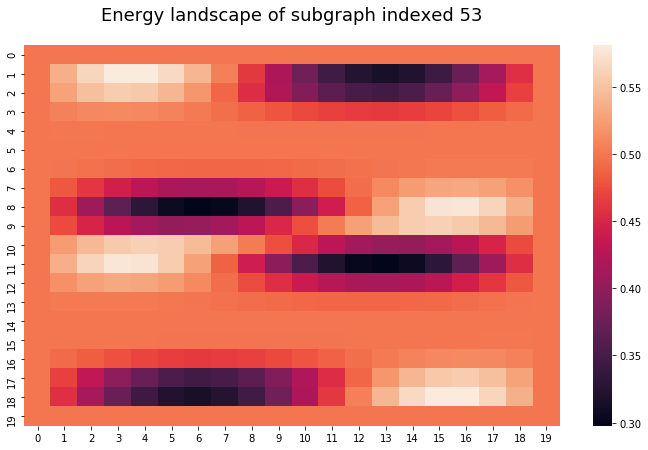

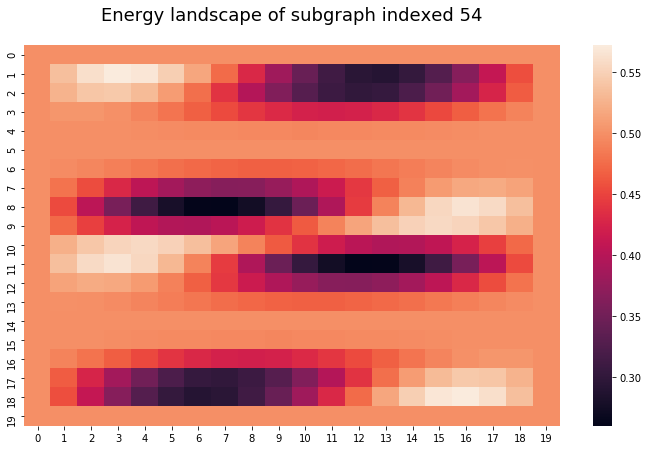

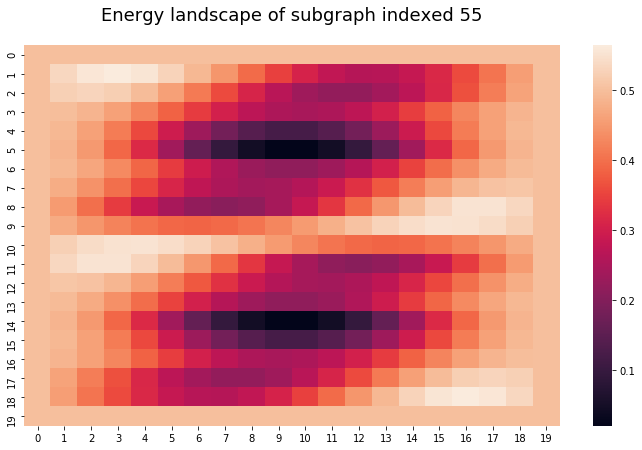

In [17]:

for k in range(len(g_all)):
    step = 20
    gamma = np.linspace(0, 1, num = step)
    beta = np.linspace(0, 0.5, num = step)
    data = np.zeros((step, step))

    for i in range(step):
      for j in range(step):
        data[step-i-1, j] = (1-get_edge_contribution(g_all[k], (0,1), [gamma[i]], [beta[j]]))/2
    fig, ax = plt.subplots(figsize = (12, 7))
    title = "Energy landscape of subgraph indexed "+str(k)
    plt.title(title, fontsize = 18)
    ttl = ax.title
    ttl.set_position([0.5, 1.05])
    sns.heatmap(data, ax = ax)
    plt.show()

In [18]:
import pandas as pd

In [47]:
df = pd.DataFrame({'x': beta, 'y':gamma})
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 4)
kmeans.fit(df)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [48]:
labels = kmeans.predict(df)
labels

array([1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2,

In [49]:
centers = kmeans.cluster_centers_
centers

array([[0.37537039, 0.24936467],
       [0.12686574, 0.74996591],
       [0.12557243, 0.73176144],
       [0.37557652, 0.2698401 ]])

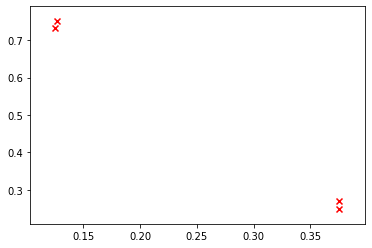

In [50]:
plt.scatter(centers[:,0], centers[:,1], marker="x", color='r')


# Doing the k means thing for all subgraphs
Assuming 4 clusters for all

In [23]:
params = None
sub = None
gamma = None
beta = None
centers = []


for k in range(len(g_all)):
    print(k)
    sub = g_all[k]
    
    old_params, energies = get_local_optima(sub,cutoff = .001, multistarts =50, steps = 200)
    params = fix_param(old_params)
    
    gamma = [float(params[i][0]) for i in range(len(params))]
    beta = [float(params[i][1]) for i in range(len(params))]
    
    df = pd.DataFrame({'x': beta, 'y':gamma})
    kmeans = KMeans(n_clusters = 4)
    kmeans.fit(df)
    labels = kmeans.predict(df)
    sub_centers = kmeans.cluster_centers_
    for row in sub_centers:
        centers.append(row)
    #centers +=sub_centers

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55


In [24]:
len(centers)

224

In [25]:
4*56

224

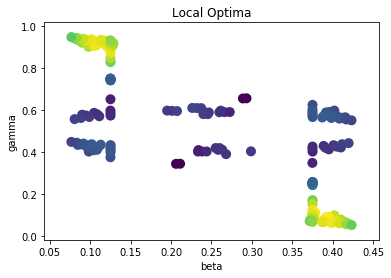

In [26]:
gamma = [float(centers[i][1]) for i in range(len(centers))]
beta = [float(centers[i][0]) for i in range(len(centers))]

#cm = plt.cm.get_cmap('Reds')

#plt.scatter(beta, gammafrom scipy.stats import gaussian_kde
from scipy.stats import gaussian_kde

fig = plt.figure(figsize = (6,4))
x =beta
y = gamma

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# fig, ax = plt.subplots()
plt.scatter(x, y, c=z, s=100, edgecolor='')
plt.xlabel("beta")
plt.ylabel("gamma")
plt.title('Local Optima')
plt.show()

In [30]:
new_centers = [list(i) for i in centers]

In [31]:
new_centers

[[0.37495592455418414, 0.24998826952466746],
 [0.12498338805473858, 0.750093454935025],
 [0.3748830576885996, 0.2558392745938469],
 [0.37500648414063614, 0.24369947422461882],
 [0.12497097102408494, 0.8333346553135789],
 [0.3749655557457262, 0.16662208117348565],
 [0.37514371204376185, 0.1709218004345881],
 [0.12508058297919872, 0.8289685894365171],
 [0.3748842254201723, 0.3482828063428106],
 [0.1249758842891087, 0.8480026642858295],
 [0.1249695525238818, 0.6517892500294866],
 [0.37499480579614997, 0.1514675239437882],
 [0.37484944704596396, 0.2501520863016663],
 [0.12499036904274005, 0.7498148563584615],
 [0.12500719195033633, 0.7434392859961115],
 [0.37549289479488257, 0.2565985885335173],
 [0.37499602318813197, 0.25007145113333384],
 [0.12496004103752198, 0.7500964579820935],
 [0.1250320990778965, 0.7424378705268003],
 [0.37506100756896543, 0.24244742608956385],
 [0.12492753722452037, 0.7498211776848521],
 [0.3749574168184436, 0.24988558062385907],
 [0.3749804888468453, 0.2573560826